# Rendu Data Challenge - Apprentissage Statistique et Fouille de données / Mathieu SAUVEUR

## Sujet : 

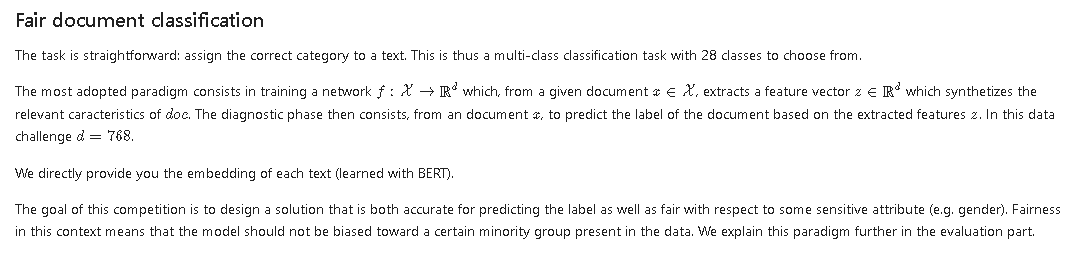

#### Dans ce notebook sont mentionné les différentes étapes de mon travail pour répondre à ce sujet.

#### Pour résumer, j'ai tout d'abord réalisé une EDA sur les données, puis j'ai réalisé un preprocessing des données, et enfin j'ai réalisé un modèle de prédiction de la variable cible.

#### Cependant, ce qui est mentionné dans ce notebook reste un apperçu de ce qui m'a permis d'arriver au score le plus élevé en ce qui me concerne (0.785633)

#### Exemple de piste de travail explorées mais non conservées : 

- Rectification du déséquilibre au niveau de la représentation des classes (méthode SMOTE, RandomUnderSampling...) car l'utilisation du paramètre weight_balanced pris par les modèles ne donnaient pas de bons résultats.
- Standardisation des données, réductions de dimensions, ...
- Différents modèles de classification (Arbres de décisions, réseaux de neurones, SGD...)

In [14]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.manifold import TSNE
from scipy.stats import pearsonr,spearmanr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from evaluator import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN,  Activation, Reshape
from tensorflow.keras.optimizers import Adam
from torch import nn, optim
from tensorflow.keras.utils import to_categorical
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier

with open('data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

# Train dataset
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
S = S.reset_index(drop=True)

## Partie I : EDA

Avant de commencer à modéliser, j'ai voulu faire une analyse exploratoire des données afin de les comprendre et de voir si d'éventuelles transformations étaient nécessaires. 

#### I.1 Analyse des features X

##### I.1.a. Propriétés des features

In [15]:
# Apperçu du contenu des features
X.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.107712,0.202686,-0.036410,-0.538686,0.162234,-0.109034,-0.075343,0.202060,-0.120114,-0.540793,...,0.058022,-0.117150,0.684212,-0.456693,0.342016,0.237988,-0.507806,0.064729,0.255565,0.510899
1,0.056359,0.003188,-0.726052,-0.616777,0.064091,-0.068786,0.384864,0.363644,-0.285173,-0.430806,...,-0.049452,-0.587354,-0.004443,-0.924459,-0.402672,0.170605,-0.074348,0.130570,0.328335,0.139750
2,-0.331249,0.210670,-0.202662,-0.654994,0.307785,-0.254564,-0.165728,0.540352,-0.184862,-0.696042,...,0.069515,-0.030068,0.616826,-0.952147,0.154724,0.262131,-0.708171,0.123852,0.537076,0.409024
3,-0.565799,0.118481,0.185003,-0.692792,-0.056820,0.039130,0.241766,-0.113560,-0.138898,-0.768206,...,-0.071413,-0.310701,0.157026,-0.691291,-0.273562,0.121746,-0.394475,-0.463161,0.132829,0.264848
4,-0.669160,-0.052143,-0.708578,-0.159049,-0.273591,0.059959,-0.134847,0.045078,-0.308037,-0.585879,...,-0.018836,-0.473991,0.177165,-0.409756,0.027797,-0.096018,-0.390492,0.211198,0.340143,0.191472


In [16]:
# Statistiques descriptives des features
X.describe() 

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,...,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000,27749.000000
mean,-0.336415,-0.000947,-0.517365,-0.503902,-0.056925,-0.028903,0.214925,0.304056,-0.136354,-0.273534,...,-0.036228,-0.378857,0.037163,-0.523419,0.014841,0.195742,-0.236731,0.149190,0.374945,0.252111
std,0.241738,0.248391,0.394988,0.259865,0.260024,0.248630,0.252762,0.259695,0.215580,0.269345,...,0.232522,0.241675,0.247942,0.267868,0.231659,0.220592,0.214325,0.288794,0.229825,0.242513
min,-1.650025,-1.140967,-1.930083,-1.560696,-1.098962,-1.385007,-0.919462,-0.884887,-1.143646,-1.376672,...,-1.137986,-1.423865,-0.965398,-2.253617,-0.968929,-0.841427,-1.128300,-1.325411,-0.500748,-0.808703
25%,-0.490549,-0.166887,-0.780339,-0.670340,-0.237157,-0.186003,0.045545,0.132983,-0.276268,-0.457085,...,-0.188929,-0.543636,-0.130416,-0.694957,-0.143412,0.054527,-0.380959,-0.039868,0.217373,0.098098
50%,-0.333451,-0.000796,-0.509399,-0.494708,-0.062312,-0.015421,0.219464,0.300846,-0.139955,-0.278111,...,-0.030984,-0.389264,0.033798,-0.511635,0.018567,0.198072,-0.240479,0.153462,0.368116,0.262574
75%,-0.176314,0.173093,-0.251268,-0.332255,0.111903,0.138569,0.382187,0.475525,-0.000645,-0.092890,...,0.117915,-0.220302,0.200731,-0.342802,0.175203,0.341546,-0.100198,0.346528,0.530264,0.416069
max,0.643118,1.039149,0.745597,0.514842,1.146440,1.031636,1.246975,1.495888,1.066777,0.736220,...,1.195685,0.689809,1.146161,0.595715,1.153498,1.180337,0.835648,1.433294,1.390707,1.238811


In [17]:
print(f"X est de dimensions : {X.shape}\n")
print(f"La valeur min globale des features est : {np.min(np.min(X))}\n")
print(f"La valeur max globale des features est : {np.max(np.max(X))}\n")
print(f"Nombre de NA = {X.isna().sum().sum()}")

X est de dimensions : (27749, 768)

La valeur min globale des features est : -8.052590370178223

La valeur max globale des features est : 5.002350807189941

Nombre de NA = 0


{'whiskers': [<matplotlib.lines.Line2D at 0x14ddde2b050>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x14e0c6f6550>,
  ...],
 'boxes': [<matplotlib.lines.Line2D at 0x14ddde9e9d0>,
 'medians': [<matplotlib.lines.Line2D at 0x14ddde062d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14ddde06750>,
 'means': []}

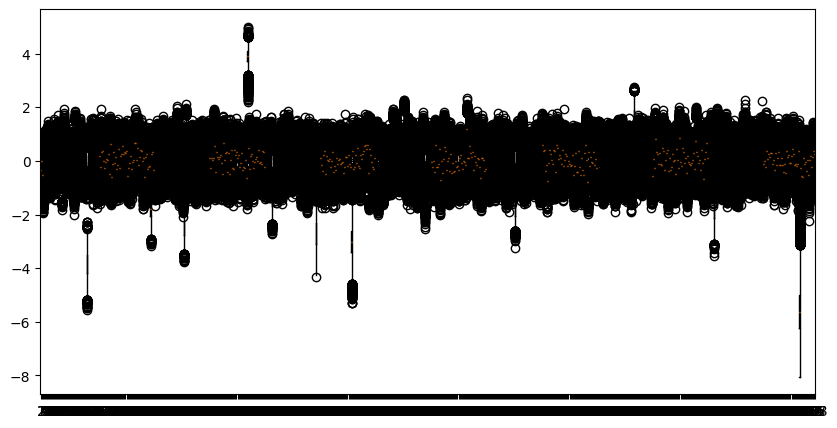

In [18]:
# Boxplot des valeurs de X afin d'observer la présence d'outliers (ce qui est peu probable car ce sont des features isues d'embeddings)
plt.figure(figsize=(10,5))
plt.boxplot(X)

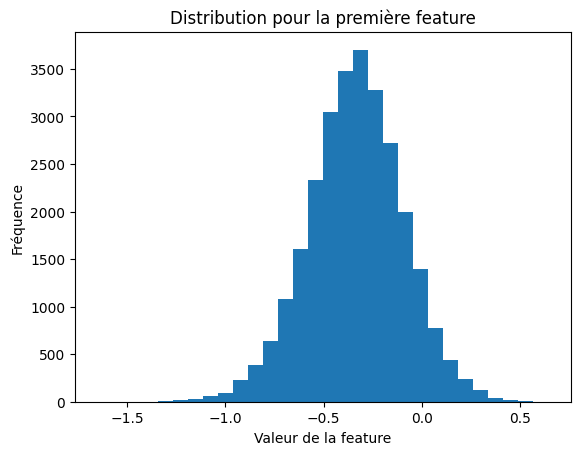

In [19]:
# Distribution pour 1 feature
plt.hist(X.iloc[:, 0], bins=30) 
plt.xlabel('Valeur de la feature')
plt.ylabel('Fréquence')
plt.title('Distribution pour la première feature')
plt.show()

Dans cette partie on remarque que les features sont plutôt bien distribuées, sans outliers ni de NaN. L'intervalle dans laquelle se trouve les valeurs des features est assez faible, ce qui est un bon point pour la suite.

##### I.1.b. Étude de la corrélation entre les features

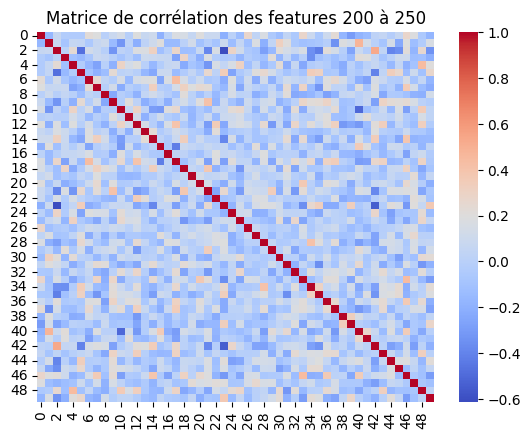

In [20]:
# Matrice de correlation

# Matrice de correlation

corr = np.corrcoef(X.iloc[:, 0:50].T)  

sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Matrice de corrélation des features 200 à 250')
plt.show()

Ici je ne peux qu'observer une faible range de la matrice de corrélation, ce qui n'est pas pertinent. Bien qu'on puisse tout de même appercevoir quelques features qui semblent être plus ou moins corrélées entre elles.
J'aurais pu faire un code qui extrait les features qui ont une correlation qui dépassent un certain seuil afin de les traiter par la suite

##### I.1.c. Visualisation des données dans un espace de dimension réduite

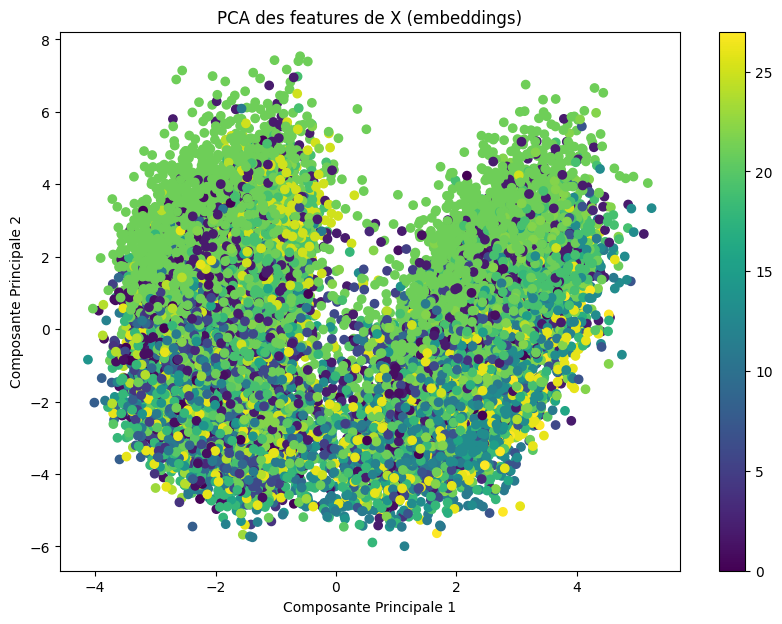

In [21]:
# PCA (Principal Component Analysis)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y) 
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar()
plt.title('PCA des features de X (embeddings)')
plt.show()

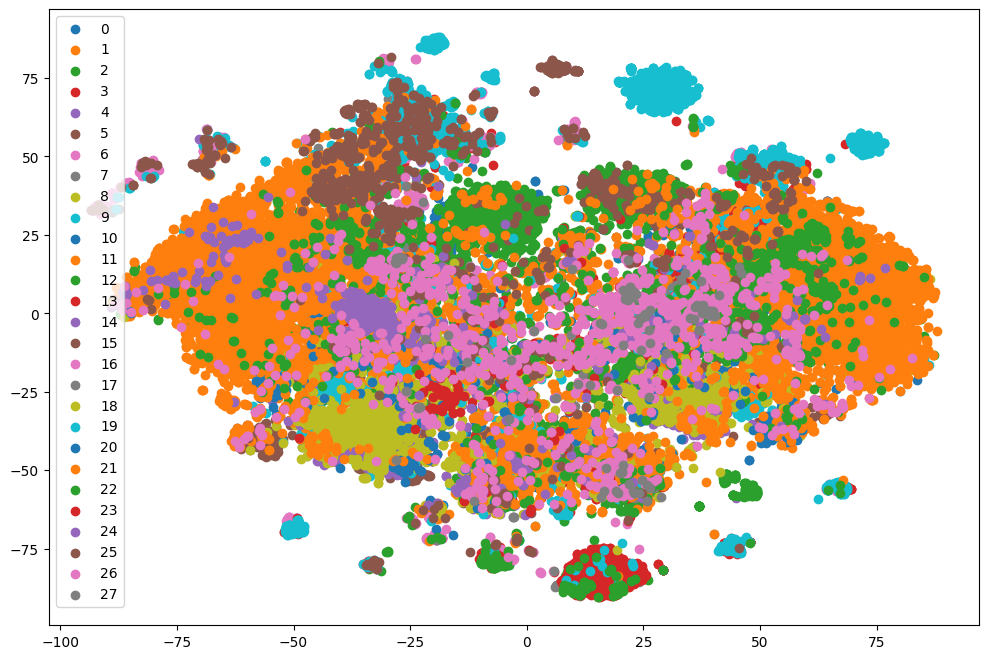

In [22]:
# t-SNE (t-distributed Stochastic Neighbor Embedding) 

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
for i in range(28): 
    indices = Y == i
    plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=i)
plt.legend()
plt.show()

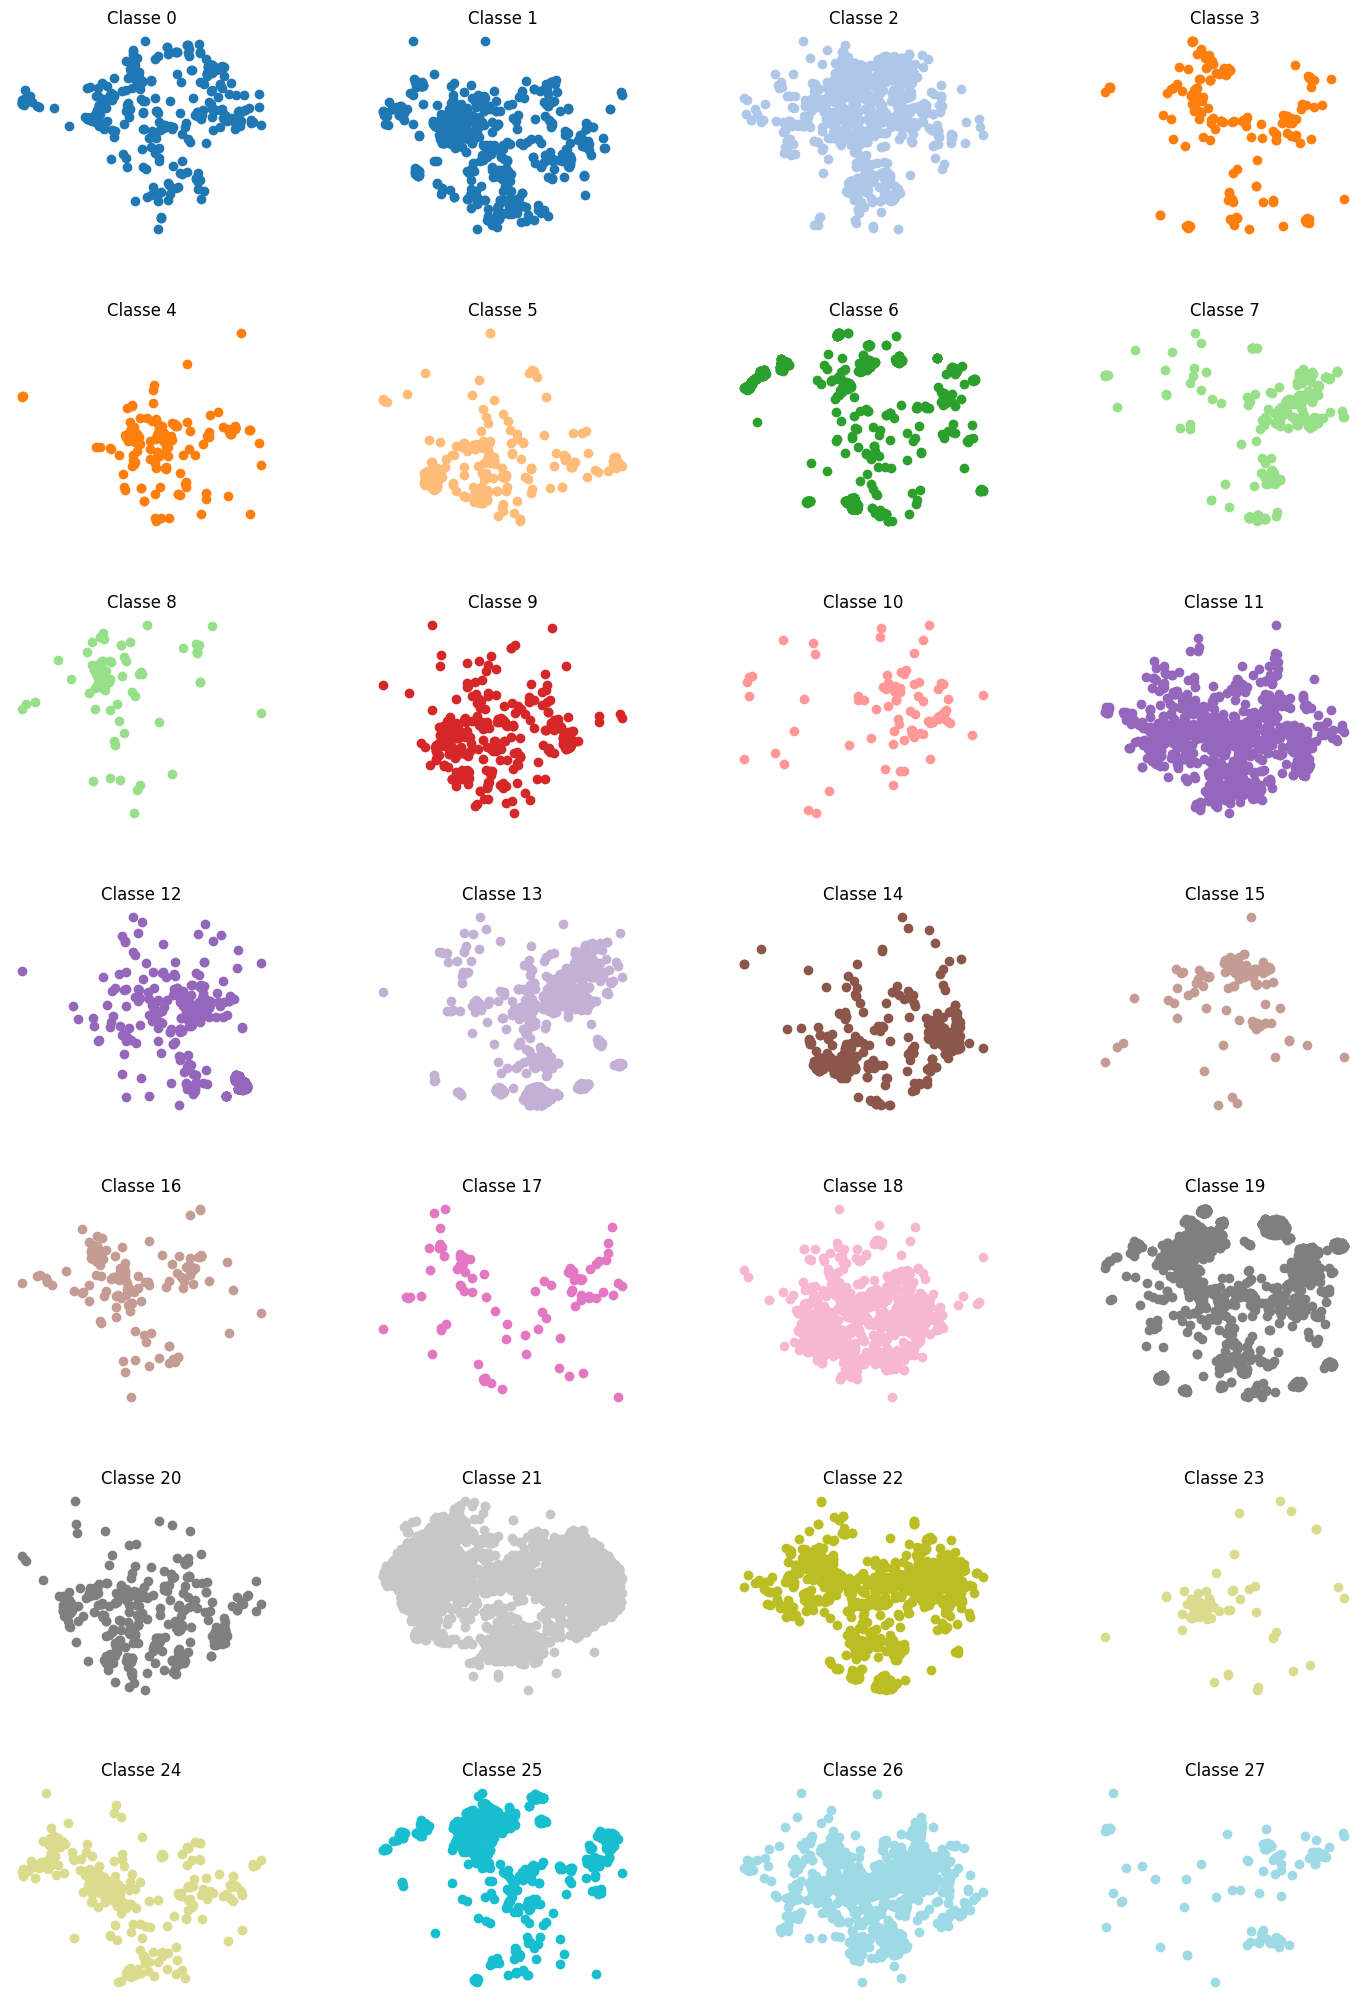

In [23]:
# t-SNE mais en séparant par classes

num_classes = 28  
cols = 4
rows = (num_classes + cols - 1) // cols 

# Créer une figure et une grille de subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
fig.tight_layout(pad=4.0)

colors = plt.cm.tab20(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    row, col = i // cols, i % cols 
    ax = axs[row, col]
    # Filtrer les données pour la classe i
    indices = Y == i
    ax.scatter(X_embedded[indices, 0], X_embedded[indices, 1], color=colors[i], label=f'Classe {i}')
    ax.set_title(f'Classe {i}')
    ax.axis('off')

# Masquer les subplots vides s'il y en a
for i in range(i+1, rows*cols):
    axs[i // cols, i % cols].axis('off')

plt.show()

De ce qu'on obtinent, les visualisations issues de la t-SNE et de l'ACP ne sont pas très concluantes. On ne peut pas distinguer les classes entre elles. Cependant, on peut voir que les données sont bien distribuées.

Étudier plus en détail la piste de la t-SNE pourrait peut être ^^etre interressante car on peut tout de même distinguer quelques pattern. Cependant, le manque de représentation de certaines classes restent un problême car rendent la t-SNE peu fiable.

##### I.1.d. Étude sur la réduction de dimensions

Ici, j'ai voulu voir s'il était pertinent de réduire les dimensions de X à un certain nombre de features importants pour conserver un maximum de variance expliquée tout et réduire le temps d'entraînement des modèles.

Cependant, faire cette réduction de dimension n'a pas améliorée les performances des modèles, j'ai donc décidé de conserver toutes les features.

In [24]:
# 1.Sélection de Features Basée sur l'importance avec un randomforest #####

# model = RandomForestClassifier()
# model.fit(X, Y)
# importances = model.feature_importances_

## Seuil d'importance

# threshold = 0.01  
# important_features = [feature for feature, importance in enumerate(importances) if importance > threshold]

# X_train_important = X_train.iloc[:, important_features]
# X_test_important = X_test.iloc[:, important_features]

## Nombre fixe 

# num_features_to_select = 150

# indices = np.argsort(importances)[::-1]

# top_indices = indices[:num_features_to_select]

# X_train_top = X.iloc[:, top_indices]
# X_test_top = X.iloc[:, top_indices]
# Y_train_top = Y[top_indices]

In [25]:
# 2. Méthodes de Sélection Univariables

# selector = SelectKBest(f_classif, k=500)  
# X_train_reduced = selector.fit_transform(X, Y)
# X_test_reduced = selector.transform(X)

In [26]:
# 3.Régularisation L1 (Lasso) pour la Sélection de Features

# lasso = LassoCV(cv=5)
# lasso.fit(X, Y)
# coef = lasso.coef_

# selected_features = [index for index, coef in enumerate(lasso.coef_) if coef != 0]

# X_train_reduced = X.iloc[:,selected_features]
# X_test_reduced = X.iloc[:,selected_features]

In [27]:
# 4 Réduction de dimensionalités avec PCA

# pca = PCA(n_components=100)
# X_train_reduced = pca.fit_transform(X)
# X_test_reduced = pca.transform(X)

### Analyse de la target Y

In [28]:
Y.head()

0     6
1     9
2     6
3    22
4    21
dtype: int64

In [29]:
Y.describe()

count    27749.000000
mean        15.990306
std          7.486705
min          0.000000
25%         11.000000
50%         19.000000
75%         21.000000
max         27.000000
dtype: float64

C:\Users\matsa\AppData\Local\Temp\ipykernel_26292\484123448.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis')


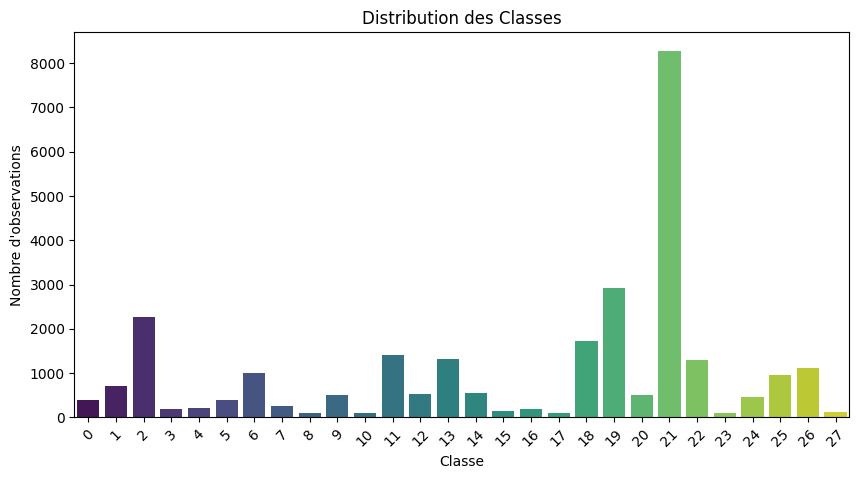

In [30]:
# Histogramme de la représentation de la variable Y

labels, counts = np.unique(Y, return_counts=True)

df_labels = pd.DataFrame({'Label': labels, 'Count': counts})

plt.figure(figsize=(10, 5))
sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis')
plt.title('Distribution des Classes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45)
plt.show()

Il y a un trop grand déséquilibre dans la représentation des classes ce qui peut poser problème pour l'apprentissage (mauvaise généralisation, bon apprentissage sur les classes les plus repésentées et moins bon pour les autres, overfitting sur les classes majoritaires.)

Les solutions pour palier à ce problème sont :
- sous-échantillonner les classes les plus représentées
- sur-échantillonner les classes les moins représentées
- utiliser des méthodes de pondération des classes (weight_balanced)
- (pour la cross-validation, s'assurer que les classes sont bien représentées dans chaque fold)

### Analyse des attributs sensibles S

In [31]:
S.head()

0    0
1    1
2    0
3    1
4    0
dtype: int64

In [32]:
S.describe()

count    27749.000000
mean         0.461026
std          0.498488
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
dtype: float64

C:\Users\matsa\AppData\Local\Temp\ipykernel_26292\1516529141.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis')


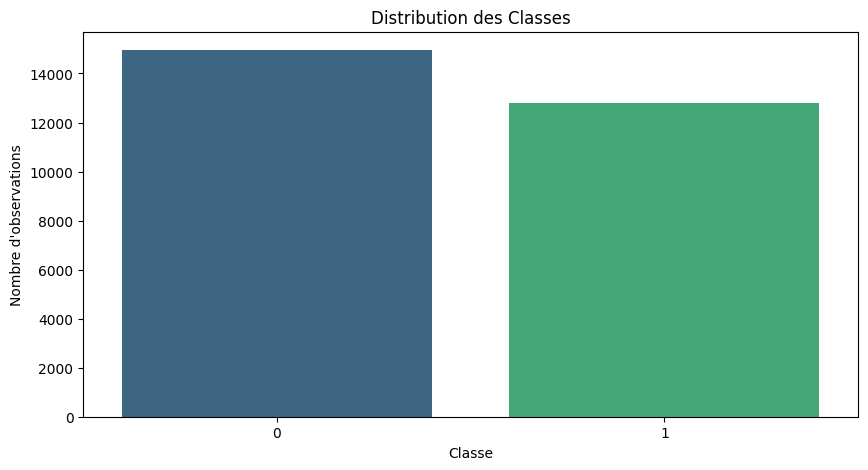

In [33]:
# Histogramme de la variable S

labels, counts = np.unique(S, return_counts=True)

df_labels = pd.DataFrame({'Label': labels, 'Count': counts})

plt.figure(figsize=(10, 5))
sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis')
plt.title('Distribution des Classes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

C:\Users\matsa\AppData\Local\Temp\ipykernel_26292\3636612863.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels0, palette='viridis')


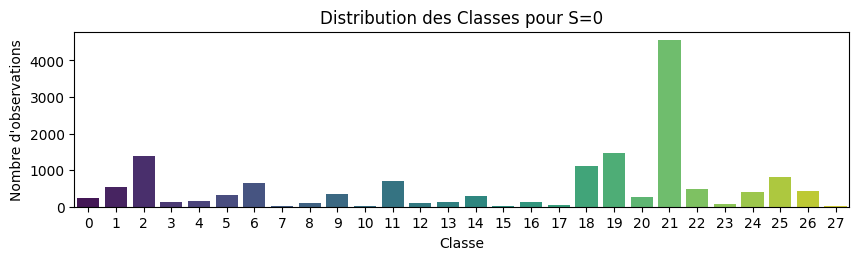

C:\Users\matsa\AppData\Local\Temp\ipykernel_26292\3636612863.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels1, palette='viridis')


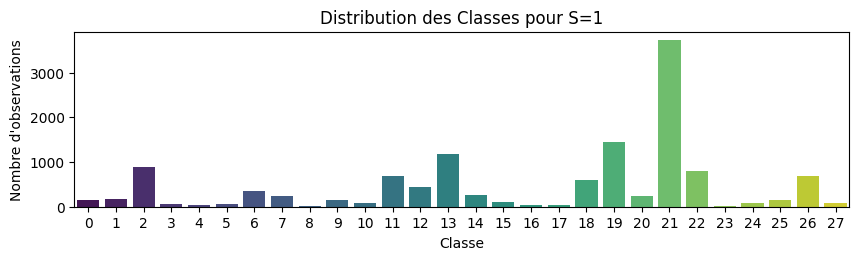

In [34]:
# Histogramme de la représentation des classes pour S=0 et S=1

dfY = Y.to_frame(name='label')
dfS = S.to_frame(name='S')

dfXYS = pd.concat([X, dfS, dfY], axis=1)

dfS0 = dfXYS.loc[dfXYS['S'] == 0]
dfS1 = dfXYS.loc[dfXYS['S'] == 1]

labels0, counts0 = np.unique(dfS0['label'], return_counts=True)
df_labels0 = pd.DataFrame({'Label': labels0, 'Count': counts0})

labels1, counts1 = np.unique(dfS1['label'], return_counts=True)
df_labels1 = pd.DataFrame({'Label': labels1, 'Count': counts1})

plt.figure(figsize=(10, 5))
plt.subplot(211)
sns.barplot(x='Label', y='Count', data=df_labels0, palette='viridis')
plt.title('Distribution des Classes pour S=0')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(212)
sns.barplot(x='Label', y='Count', data=df_labels1, palette='viridis')
plt.title('Distribution des Classes pour S=1')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

D'après les observations, il y a bien un déséquilibre dans la représentation des classes de S ce qui peut conduire à des biais dans les prédictions des modèles. Pour résoudre ce problème et entraîner des modèles pour qu'ils soient plus équitables, j'ai rétabli l'équilibre des classes de S en utilisant la méthode un OverSampling sur les classes les moins représentées de chaque S afin qu'il y ait à la fin un même nombre d'homme et de femme dans la population globale

## Partie II : Preprocessing des données

Cette partie consiste à transformer les données pour les rendre plus pertinentes. 

Je fais d'abord un train_test_split pour séparer les données en train et test set avec les bonnes propriétés, puis je concatène X, Y et S dans un seul dataframe pour pouvoir les traiter ensemble.
Ensuite je résout le problème de déséquilibrage au niveau de l'attribut sensible en utilisant la méthode de l'oversampling (RandomOverSampler) pour équilibrer les classes.

In [35]:
# Séparation des données en jeu d'entraînement et jeu de test

X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, stratify=Y) 

# J'enlève la spécification du random_seed(42) afin de tester plusieurs splits et déterminer s'il y en a qui sont plus avantageux que de d'autres.

# Je rajoute un stratify=Y pour m'assurer que les classes soient bien réparties dans les jeux de données.

# J'ai fais également train et test mon modèle le plus performant sur plusieurs tailles différents (plusieurs test_size)

In [36]:
# Après plusieurs tests, j'ai stocké dans 'best_train_data' le jeu de données qui a donné les meilleurs résultats pour mon modèle. 
# Je le sotcke dans une variable pour le éutiliser pour tester d'éventuels changements dans mon modèle.

df_train_best = pd.read_csv('Best_train_data.csv')

In [37]:
# Je fusionne les 768 featuers de X et la variable sensible S dans X_b_train et X_b_test
X_b_train = pd.concat([X_train, S_train.to_frame(name='S')], axis=1)
X_b_test = pd.concat([X_test, S_test.to_frame(name='S')], axis=1)
X_b_train.columns = X_b_train.columns.astype(str)
X_b_test.columns = X_b_test.columns.astype(str)

# Je fais la même chose mais en standardisant les données de X avant de les fusionner avec S
# scaler = StandardScaler()
# X_train_sca = pd.DataFrame(scaler.fit_transform(X_train))
# X_b_train_sca = pd.concat([X_train_sca.reset_index(drop=True), S_train.reset_index(drop=True)], axis=1)
# X_b_train_sca.coloumns = X_b_train.columns.astype(str)

# X_test_sca = pd.DataFrame(scaler.fit_transform(X_test))
# X_b_test_sca = pd.concat([X_test_sca.reset_index(drop=True), S_test.reset_index(drop=True)], axis=1)
# X_b_test_sca.coloumns = X_b_test.columns.astype(str)

# Dans un seul dataframe je regorupe X_b_train et Y_train
df = pd.concat([X_b_train, Y_train.to_frame(name='label')], axis=1)


La classe 0 est sous-représentée pour S=1
La classe 1 est sous-représentée pour S=1
La classe 2 est sous-représentée pour S=1
La classe 3 est sous-représentée pour S=1
La classe 4 est sous-représentée pour S=1
La classe 5 est sous-représentée pour S=1
La classe 6 est sous-représentée pour S=1
La classe 7 est sous-représentée pour S=0
La classe 8 est sous-représentée pour S=1
La classe 9 est sous-représentée pour S=1
La classe 10 est sous-représentée pour S=0
La classe 11 est sous-représentée pour S=1
La classe 12 est sous-représentée pour S=0
La classe 13 est sous-représentée pour S=0
La classe 14 est sous-représentée pour S=1
La classe 15 est sous-représentée pour S=0
La classe 16 est sous-représentée pour S=1
La classe 17 est sous-représentée pour S=1
La classe 18 est sous-représentée pour S=1
La classe 19 est sous-représentée pour S=0
La classe 20 est sous-représentée pour S=0
La classe 21 est sous-représentée pour S=1
La classe 22 est sous-représentée pour S=0
La classe 23 est sous

C:\Users\matsa\AppData\Local\Temp\ipykernel_26292\3513604180.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels0, palette='viridis')


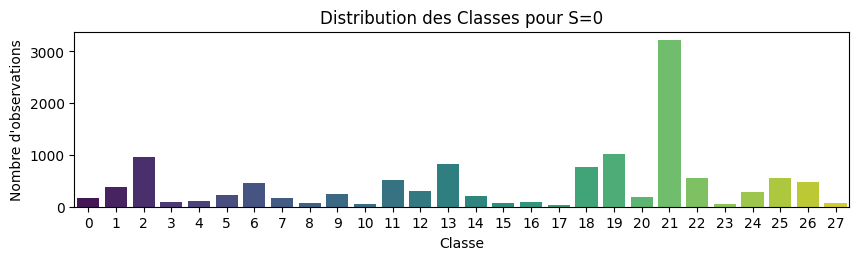

C:\Users\matsa\AppData\Local\Temp\ipykernel_26292\3513604180.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels1, palette='viridis')


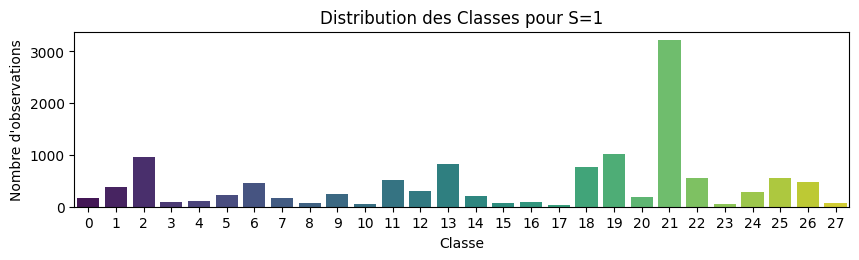

In [38]:
# Premier resampling pour équilibrer le ratio homme/femme dans le jeu de données
# On sépare le dataframe initial en 2 dataframes : un pour les S0 et un pour les S1
# Pour chaque classe, on regarde le nombre d'observations pour S0 et S1, on prend le maximum et on équilibre les classes vers le maximum

X_train_a_res, Y_train_a_res = df.iloc[:,:-1], df['label']
df_s0 = df.loc[df['S']==0]
df_s1 = df.loc[df['S']==1]

# Si je veux faire un under-sampling afin de réduire les classes majoritaires ou sur-repésentées comme la classe 21

# rus = RandomUnderSampler(sampling_strategy={21: 2200})
# X_s0__res1, Y_s0_res1 = rus.fit_resample(df_s0.iloc[:,:-1], df_s0['label'])
# X_s1_res1, Y_s1_res1 = rus.fit_resample(df_s1.iloc[:,:-1], df_s1['label']) 

# df_s0 = pd.concat([X_s0__res1, Y_s0_res1], axis=1)
# df_s1 = pd.concat([X_s1_res1, Y_s1_res1], axis=1)


sampling_strategy_over_s0 = defaultdict(int)
sampling_strategy_over_s1 = defaultdict(int)

for label in np.unique(df['label']):

    counts0 = df_s0[df_s0['label']==label].shape[0]
    counts1 = df_s1[df_s1['label']==label].shape[0]
    idx = 0

    if  counts0 < counts1:
        print('La classe {} est sous-représentée pour S=0'.format(label))
        sampling_strategy_over_s0[label] = counts1
    elif counts0 > counts1:
        print('La classe {} est sous-représentée pour S=1'.format(label))
        sampling_strategy_over_s1[label] = counts0


ros_s0 = RandomOverSampler(sampling_strategy=sampling_strategy_over_s0)
ros_s1 = RandomOverSampler(sampling_strategy=sampling_strategy_over_s1)

X_s0_res, Y_s0_res = ros_s0.fit_resample(df_s0.iloc[:,:-1], df_s0['label']) if sampling_strategy_over_s0 else (df_s0.iloc[:,:-1], df_s0['label'])
X_s1_res, Y_s1_res = ros_s1.fit_resample(df_s1.iloc[:,:-1], df_s1['label']) if sampling_strategy_over_s1 else (df_s1.iloc[:,:-1], df_s1['label'])

X_train_res = pd.concat([X_s0_res, X_s1_res], axis=0)
Y_train_res = pd.concat([Y_s0_res, Y_s1_res], axis=0)
df_train_res1 = pd.concat([X_train_res, Y_train_res], axis=1)

# On affiche la distribution des classes pour S=0 et S=1 après resampling

labels0, counts0 = np.unique(df_train_res1.loc[df_train_res1['S']==0]['label'], return_counts=True)
df_labels0 = pd.DataFrame({'Label': labels0, 'Count': counts0})

labels1, counts1 = np.unique(df_train_res1.loc[df_train_res1['S']==1]['label'], return_counts=True)
df_labels1 = pd.DataFrame({'Label': labels1, 'Count': counts1})

plt.figure(figsize=(10, 5))
plt.subplot(211)
sns.barplot(x='Label', y='Count', data=df_labels0, palette='viridis')
plt.title('Distribution des Classes pour S=0')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(212)
sns.barplot(x='Label', y='Count', data=df_labels1, palette='viridis')
plt.title('Distribution des Classes pour S=1')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

## Partie III : Modeling

Ici, j'ai testé plusieurs modèles de machine learning pour voir lequel était le plus performant sur ce jeu de données.
Parmi eux, il y a : 
- Régression logistique
- Dense Neural Network (DNN)
- Recurrent Neural Network (RNN)
- Stochastic Gradient Descent (SGD)
- Support Vector Machine (SVM)
- XGBoost

Je n'ai pas utilisé pyCaret pour déterminer le meilleur modèle mais je les ai testé séparement pour voir lequel était le plus performant.

#### III.1 Modèles non concluants

Ici sont présentés des extraits de code relatifs à chaque modèle testé tous commentés car ne nous intéresse pas particulièrement.

##### 1) DNN

In [39]:
# # Nombre de features en entrée
# input_shape = 769
# # Nombre de classes uniques dans vos labels
# num_classes = 28 

# # Création du modèle
# model = Sequential([
#     Dense(512, activation='relu', input_shape=(input_shape,)),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes, activation='softmax')  
# ])

# # Compilation du modèle
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',  
#               metrics=['accuracy'])

# model.summary()  

# # Entraînement du modèle
# history = model.fit(df_train_res1.iloc[:,:-2], df_train_res1.iloc[:,-1], 
#                     epochs=15, 
#                     batch_size=64, 
#                     validation_split=0.2,  
#                     verbose=1)

# plt.plot(history.history['loss'], label='Training Loss')

# # Évaluation du modèle sur les données de test
# test_loss, test_acc = model.evaluate(X_b_test, Y_test, verbose=2)
# print('\nTest accuracy:', test_acc)

# Y_pred = model.predict(X_b_test.iloc[:,:-1])
# Y_pred = np.argmax(Y_pred, axis=1)
# print(classification_report(Y_test, Y_pred))


# Y_pred = model.predict(X_b_test.iloc[:,:-1])
# predicted_classes = np.argmax(Y_pred, axis=1)

# eval_scores, confusion_matrices_eval = gap_eval_scores(predicted_classes, Y_test, S_test, metrics=['TPR'])

# final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

# print(final_score)

##### 2) RNN

In [40]:
# # Nombre de features pour chaque input (taille des embeddings)
# embedding_dim = 768 

# # Nombre de classes pour la classification
# num_classes = 28

# model = Sequential()
# model.add(Dense(100, activation='relu', input_shape=(embedding_dim,)))
# model.add(Reshape((1, -1)))
# model.add(SimpleRNN(128))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

# Y_train_one_hot = to_categorical(Y_train, num_classes=num_classes)
# Y_test_one_hot = to_categorical(Y_test, num_classes=num_classes)
# model.fit(X_train, Y_train_one_hot, batch_size=16, epochs=10, validation_data=(X_test, Y_test_one_hot))

# predictions = model.predict(X_test)

# predicted_classes = predictions.argmax(axis=-1)

# len(predicted_classes)

# acc = accuracy_score(Y_test, predicted_classes)

# print(f"L'accuracy du modèle par rapport aux prédictions qui avaient déjà été faites est : {acc}")

# eval_scores, confusion_matrices_eval = gap_eval_scores(predicted_classes, Y_test, S_test, metrics=['TPR'])

# final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
# score = eval_scores['macro_fscore']
# fairness = 1-eval_scores['TPR_GAP']

# print(final_score)
# print(score)
# print(fairness)

##### 3) SGD

In [41]:
# # Création d'un pipeline qui standardise les données puis applique SGDClassifier
# pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', penalty='elasticnet', l1_ratio= 0.2,  max_iter=1500, tol=1e-3, random_state=42))

# # Entraînement du modèle
# pipeline.fit(X_train, Y_train)

# # Évaluation du modèle
# y_pred = pipeline.predict(X_test)
# print(classification_report(Y_test, y_pred))

# Y_pred = pipeline.predict(X_test)

# eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])

# final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

# print(final_score)

##### 4) SVM

In [42]:
# # Noyau RBF
# pipeline1 = make_pipeline(StandardScaler(), SVC(kernel='rbf', decision_function_shape='ovo')) 

# pipeline1.fit(df_train_res1.iloc[:,:-2], df_train_res1.iloc[:,-1])

# y_pred_rbf = pipeline1.predict(X_b_test.iloc[:,:-1])

# print(classification_report(Y_test, y_pred_rbf))

# # Noyau lineaire
# pipeline2 = make_pipeline(StandardScaler(), SVC(kernel='linear', decision_function_shape='ovo'))

# # Noyau polynomial
# pipeline3 = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=3, coef0=1, decision_function_shape='ovo'))

##### 5) XGBoost

In [43]:
# model = XGBClassifier(colsample_bytree=0.1, eta=0.1, gamma=0.2, max_depth=8, min_child_weight=5, n_estimators=70, subsample=0.6)

# eval_set = [(df_train_res1.iloc[:,:-1], df_train_res1.iloc[:,-1]), (X_b_test, Y_test)]
# model.fit(df_train_res1.iloc[:,:-1], df_train_res1.iloc[:,-1], eval_metric="mlogloss", eval_set=eval_set, verbose=True)

# # Récupérer les résultats
# results = model.evals_result()
# print(results)

# y_pred = model.predict(X_b_test)

# eval_scores, confusion_matrices_eval = gap_eval_scores(y_pred, Y_test, X_b_test.iloc[:,-1], metrics=['TPR'])

# final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

# print(json.dumps(eval_scores, indent=4))
# print(final_score)

#### III.2 Crossvalidation pour la régression logistique

Ici, je fais une crossvalidation pour trouver les meilleurs hyperparamètres pour mon modèle de régression logistique
J'utilise GridSearchCV qui va tester toutes les combinaisons de paramètres possibles afin de me ressortir ceux qui ont donné les meilleurs résultats (basé sur le f1_score)
J'aurais aussi pu utiliser RandomizedSearchCV qui aurait été beaucoup plus rapide mais moins précis car choisi aléatoireemnt les combinaisons de paramètres à tester.

In [44]:
# f1_scorer = make_scorer(f1_score, average="weighted")  

# param_grid = {
#     'C': np.linspace(0.1, 10, 15),  
#     'solver': ['newton-cg'],
#     'max_iter': [5000],
#     'multi_class': ['auto'], 
#     # 'class_weight' : ['balanced', 'None'],
#     # 'random_state': [42]
# }

# cv = StratifiedKFold(n_splits=2, shuffle=True)

# model = LogisticRegression()

# grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=f1_scorer, verbose=2)

# # grid_search.fit(X_train, Y_train)
# # grid_search.fit(X_b_train, Y_train)

# print("Meilleurs paramètres:", grid_search.best_params_)
# print("Meilleur score (accuracy):", grid_search.best_score_)

# best_model = grid_search.best_estimator_

# Y_pred = best_model.predict(X_test)
# # Y_pred = best_model.predict(X_b_test)

# eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
# # eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, X_b_test.iloc[:,-1], metrics=['TPR'])

# final_score = (eval_scores['macro_fscore'] + (1 - eval_scores['TPR_GAP'])) / 2

# print(json.dumps(eval_scores, indent=4))
# print(eval_scores['macro_fscore'])
# print(final_score)

#### III.3 Entraînement et évaluation de la régression logistique 

In [47]:
# Classifier built on the training data
clf = LogisticRegression(C= 0.115, solver='newton-cg', multi_class='auto', max_iter=5000, verbose=2).fit(df_train_best.iloc[:,:-2], df_train_best.iloc[:,-1]) 

# Prediction on the test data
Y_pred = clf.predict(X_b_test.iloc[:,:-1])

# Evaluation of the classifier
eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, X_b_test.iloc[:,-1], metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(json.dumps(eval_scores, indent=4))
print(final_score)

{
    "accuracy": 0.8267867867867867,
    "macro_fscore": 0.7871848909753096,
    "micro_fscore": 0.8267867867867867,
    "TPR_GAP": 0.12045905084511592
}
0.8333629200650969


##### **Pour l'entraînement de ma régression logistique, je n'ai pas pris en compte les attributs sensibles et cela m'a donné un meilleur score !**

In [49]:
# Submission file

# Load the "true" test data
X_test2 = dat['X_test']
S_test2 = dat['S_test'] 

# Concatenate the test data with the sensitive attribute
# X_test3 = pd.concat([X_test2, S_test2], axis=1)
# X_test3.columns = X_test3.columns.astype(str)
# if "gender_class" in X_test3.columns:
#     X_test3.rename(columns={"gender_class": "S"}, inplace=True)


y_test = clf.predict(X_test2)

results=pd.DataFrame(y_test, columns= ['score'])

results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)

c:\Users\matsa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Résumé des résultats obtenus :

Dans les toutes les conditions mentionnées ci-dessus, j'ai obtenu les résultats ci-dessous :

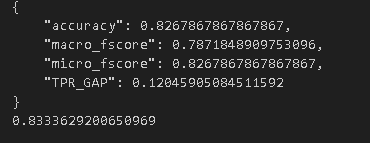


Les méthodes utilisées peuvent encore être améliorées et optimisées. D'autres pistes (non exhaustives) d'études sont mentionnées ci-dessous :

- Potentiellement entraîner les modèles sur toutes les données disponibles
- Recreuser la piste de la réduction de dimensions 
- Refaire des crossvalidations plus en prodeur, en prenant des plage de paramètres plus fines
- Réaliser du bagging en utilisant plusieurs modèles de régression logistique